## `พัฒนาโมเดล Machine Learning`

### **ที่มาของ Dataset**

[Kaggle Most Streamed Spotify Songs 2024](https://www.kaggle.com/datasets/nelgiriyewithana/most-streamed-spotify-songs-2024/data)


> Dataset นี้มาจาก Kaggle ซึ่งรวบรวมข้อมูลเกี่ยวกับเพลงที่มีการสตรีมมากที่สุดบน Spotify ในปี 2024


### **คำอธิบาย Features ของ Dataset**


> Dataset นี้มี Features ที่หลากหลาย ซึ่งอธิบายลักษณะต่างๆ ของเพลงและสถิติการฟัง

1.   Artist: ชื่อศิลปิน
2.   Album Name: ชื่ออัลบั้ม
3.   Release Date: วันที่วางจำหน่ายเพลง
4.   Spotify Streams: จำนวนการสตรีมบน Spotify
5.   YouTube Views: จำนวนการดูบน YouTube
6.   TikTok Likes: จำนวนการกดถูกใจบน TikTok
7.   AirPlay Spins: จำนวนการเปิดเพลงบน AirPlay
8.   Spotify Popularity: ความนิยมของเพลงบน Spotify

ขนาดของ Dataset: (4600, 29)

ตัวอย่างข้อมูล 5 แถวแรก:
                        Track                    Album Name          Artist  \
0         MILLION DOLLAR BABY  Million Dollar Baby - Single   Tommy Richman   
1                 Not Like Us                   Not Like Us  Kendrick Lamar   
2  i like the way you kiss me    I like the way you kiss me         Artemas   
3                     Flowers              Flowers - Single     Miley Cyrus   
4                     Houdini                       Houdini          Eminem   

  Release Date          ISRC All Time Rank  Track Score Spotify Streams  \
0    4/26/2024  QM24S2402528             1        725.4     390,470,936   
1     5/4/2024  USUG12400910             2        545.9     323,703,884   
2    3/19/2024  QZJ842400387             3        538.4     601,309,283   
3    1/12/2023  USSM12209777             4        444.9   2,031,280,633   
4    5/31/2024  USUG12403398             5        423.3     107,034,922   

  Spotify Playlist C

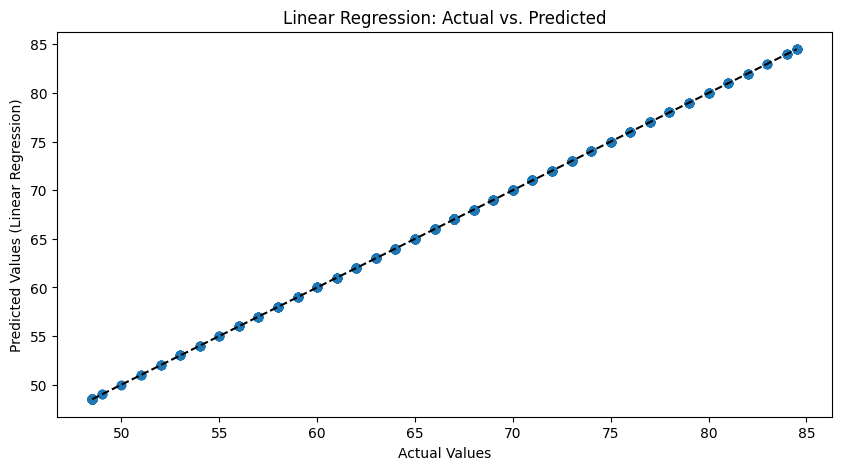

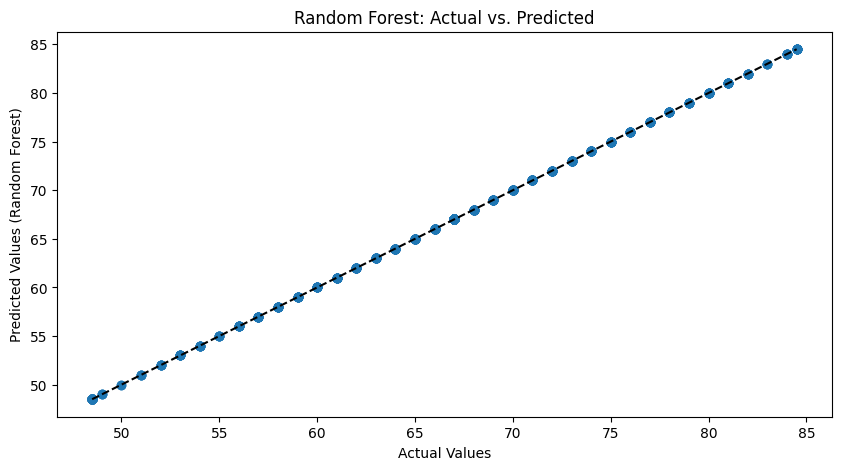

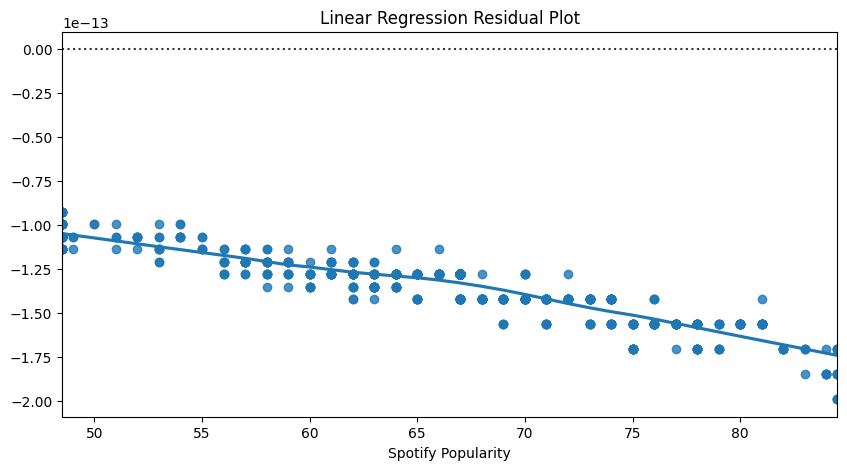

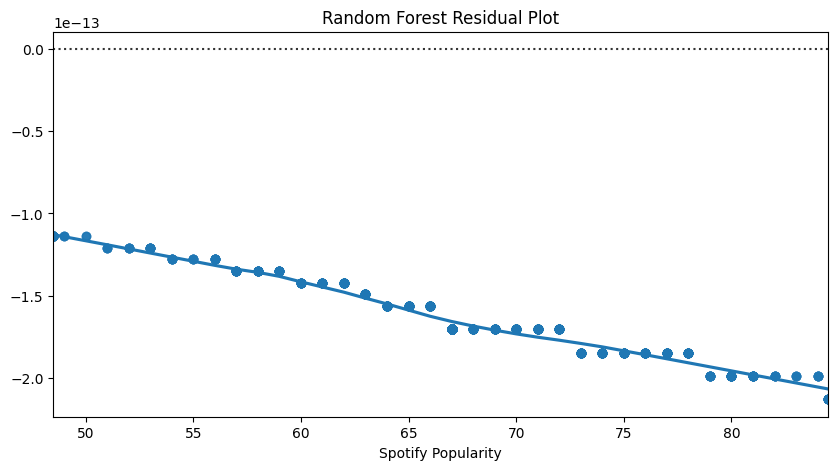

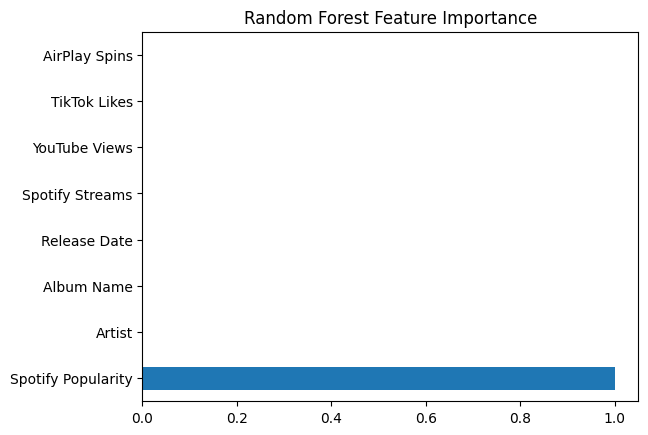

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle

# โหลดข้อมูล (พร้อมระบุ encoding)
file_path = "Most Streamed Spotify Songs 2024.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# สำรวจข้อมูลเบื้องต้น
print("ขนาดของ Dataset:", df.shape)
print("\nตัวอย่างข้อมูล 5 แถวแรก:")
print(df.head())
print("\nประเภทข้อมูลของแต่ละคอลัมน์:")
print(df.dtypes)
print("\nค่า Missing Values ในแต่ละคอลัมน์:")
print(df.isnull().sum())
print("\nค่าสถิติเบื้องต้นของคอลัมน์ numerical:")
print(df.describe())
print("\nค่า unique ของคอลัมน์ categorical:")
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].unique()}")

# การเตรียมข้อมูล (Data Preprocessing)

# จัดการกับ Missing Values (วิธีใหม่)
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include='object').columns

# เติมค่า Missing Values สำหรับคอลัมน์ตัวเลขด้วยค่ามัธยฐาน
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# เติมค่า Missing Values สำหรับคอลัมน์ประเภทวัตถุด้วยค่าที่พบบ่อยที่สุด
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# ตรวจสอบ Missing Values อีกครั้ง
print("\nค่า Missing Values หลังจัดการ:")
print(df.isnull().sum())

# จัดการกับ Outliers (ตัวอย่าง: ใช้ IQR)
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
    return df

numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    df = remove_outliers(df, col)

# จัดการกับรูปแบบวันที่ที่ไม่สอดคล้องกัน
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')
df['Release Date'] = df['Release Date'].fillna(df['Release Date'].mean())

# แปลง Release Date เป็นจำนวนวันนับจาก epoch
df['Release Date'] = (df['Release Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')

# แปลงข้อมูล Categorical เป็น Numerical
label_encoder = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = label_encoder.fit_transform(df[col])

# เลือก Feature และ Target
features = ['Artist', 'Album Name', 'Release Date', 'Spotify Streams', 'YouTube Views', 'TikTok Likes', 'AirPlay Spins', 'Spotify Popularity']
target = 'Spotify Popularity'
track_col = 'Track Name' # แก้ไขตรงนี้

X = df[features]
y = df[target]

# แบ่งข้อมูลเป็น Train และ Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling ข้อมูล
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# พัฒนาโมเดล Machine Learning

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_predictions = linear_model.predict(X_test)

# Random Forest Regressor
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)
random_forest_predictions = random_forest_model.predict(X_test)

# ประเมินผล
print("Linear Regression:")
print("MSE:", mean_squared_error(y_test, linear_predictions))
print("R2:", r2_score(y_test, linear_predictions))

print("\nRandom Forest Regressor:")
print("MSE:", mean_squared_error(y_test, random_forest_predictions))
print("R2:", r2_score(y_test, random_forest_predictions))

# เพิ่มส่วนนี้เพื่อแสดงชื่อเพลง
if track_col in df.columns: # ตรวจสอบว่ามีคอลัมน์ชื่อ Track Name
    print("\nLinear Regression Predictions with Song Names:")
    for i in range(len(y_test)):
        song_name = df.loc[y_test.index[i], track_col]
        print(f"Song: {song_name}, Predicted: {linear_predictions[i]:.2f}, Actual: {y_test.iloc[i]:.2f}")

    print("\nRandom Forest Predictions with Song Names:")
    for i in range(len(y_test)):
        song_name = df.loc[y_test.index[i], track_col]
        print(f"Song: {song_name}, Predicted: {random_forest_predictions[i]:.2f}, Actual: {y_test.iloc[i]:.2f}")
else:
    print("Column 'Track Name' not found in DataFrame.")

# กราฟ Scatter Plot (Linear Regression)
plt.figure(figsize=(10, 5))
plt.scatter(y_test, linear_predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values (Linear Regression)")
plt.title("Linear Regression: Actual vs. Predicted")
plt.show()

# กราฟ Scatter Plot (Random Forest)
plt.figure(figsize=(10, 5))
plt.scatter(y_test, random_forest_predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values (Random Forest)")
plt.title("Random Forest: Actual vs. Predicted")
plt.show()

# กราฟ Residual Plot (Linear Regression)
plt.figure(figsize=(10, 5))
sns.residplot(x=y_test, y=linear_predictions, lowess=True)
plt.title("Linear Regression Residual Plot")
plt.show()

# กราฟ Residual Plot (Random Forest)
plt.figure(figsize=(10, 5))
sns.residplot(x=y_test, y=random_forest_predictions, lowess=True)
plt.title("Random Forest Residual Plot")
plt.show()

# กราฟ Feature Importance (Random Forest)
feature_importance = pd.Series(random_forest_model.feature_importances_, index=features)
feature_importance.nlargest(10).plot(kind='barh')
plt.title("Random Forest Feature Importance")
plt.show()

# บันทึก Linear Regression Model
pickle.dump(linear_model, open('linear_model.pkl', 'wb'))

# บันทึก Random Forest Model
pickle.dump(random_forest_model, open('random_forest_model.pkl', 'wb'))

## `พัฒนาโมเดล Neural Network`

### **ที่มาของ Dataset**

[Kaggle Foods in Thailand](https://www.kaggle.com/datasets/ponthakornsodchun/foods-in-thailand)


> Dataset นี้มาจาก Kaggle ชุดข้อมูลนี้ประกอบด้วยรายการอาหารไทยดั้งเดิม ซึ่งให้ข้อมูลเกี่ยวกับชื่อภาษาอังกฤษและชื่อภาษาไทย, ส่วนผสม, ประเภทของจาน, จังหวัดที่มาของอาหาร และภูมิภาคในประเทศไทย ชุดข้อมูลนี้มีจุดประสงค์เพื่อเป็นแหล่งข้อมูลที่ครอบคลุมสำหรับผู้ที่สนใจในอาหารไทย ไม่ว่าจะเป็นนักวิจัย, ผู้ที่หลงใหลในอาหาร, หรือพ่อครัว


### **คำอธิบาย Features ของ Dataset**


> Dataset นี้มี Features ที่หลากหลาย

In [10]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np

# โหลดข้อมูล
df = pd.read_csv("thailand_foods.csv").dropna()

# ลบคอลัมน์ที่ไม่จำเป็น
df = df.drop(columns=['en_name', 'th_name', 'province'])

# แปลง ingredients เป็น One-Hot Encoding
mlb = MultiLabelBinarizer()
df['ingredients'] = df['ingredients'].apply(lambda x: x.split('+'))
ingredients_encoded = mlb.fit_transform(df['ingredients'])

# แปลงข้อมูลหมวดหมู่เป็นตัวเลข
cat_cols = ["course", "region"]
num_cols = []  # ไม่มีคอลัมน์ตัวเลขในชุดข้อมูลนี้

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols)
])

X_cat = preprocessor.fit_transform(df[cat_cols])

# รวม Features
X = np.hstack((ingredients_encoded, X_cat.toarray()))
y = df['region'].astype("category").cat.codes  # แปลง target เป็นตัวเลข

# แบ่งข้อมูล
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# คำนวณ Class Weights
class_weights = {i: (len(y_train) / np.bincount(y_train))[i] for i in range(len(np.unique(y_train)))}

# ขนาดของ Input
input_shape = (X_train.shape[1],)

# โมเดลที่เร็วขึ้นและมี accuracy สูง
model = keras.Sequential([
    keras.layers.Input(shape=input_shape),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(len(np.unique(y)), activation="softmax")
])

# ใช้ Learning Rate Scheduler
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

# เทรนโมเดล
history = model.fit(X_train, y_train, epochs=100, batch_size=512, validation_data=(X_test, y_test),
                    verbose=1, callbacks=[early_stopping, lr_scheduler], class_weight=class_weights)

# ประเมินผล
test_loss, test_acc = model.evaluate(X_test, y_test)
train_acc = max(history.history.get("accuracy", [0])) * 100

print(f"✅ Train Accuracy: {train_acc:.2f}%")
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")

# บันทึก Neural Network Model เป็น .h5
model.save('neural_network_model.h5')

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.1769 - loss: 18.2839 - val_accuracy: 0.1692 - val_loss: 1.7371 - learning_rate: 0.0050
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.5231 - loss: 10.3339 - val_accuracy: 0.6000 - val_loss: 1.6578 - learning_rate: 0.0050
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.6423 - loss: 5.1312 - val_accuracy: 0.8769 - val_loss: 1.5750 - learning_rate: 0.0050
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8385 - loss: 2.6808 - val_accuracy: 0.9077 - val_loss: 1.4949 - learning_rate: 0.0050
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8269 - loss: 2.5490 - val_accuracy: 0.9385 - val_loss: 1.4153 - learning_rate: 0.0050
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9038 - loss: 1.7943 - val_accuracy: 0.9385 - val_loss: 1.3387 - learning_rate: 0.0050
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9423 - loss: 1.2572 - val_accur

✅ Train Accuracy: 100.00%
✅ Test Accuracy: 89.23%
